<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems
### Lectures on Julia for HPC


# Distributed Jacobi (SOR) method

by Francesc Verdugo (VU Amsterdam)

Version fall 2022

## Contents

- How to parallelize the Jacobi method in Julia

## Mathematical background


### 1D Laplace equation


Find a function $u(x)$ such that


$u''(x) = 0 $ for $x\in(0,L)$

$u(0) = -1$

$u(L) = 1$



### Analytical solution

$u(x) = (x-L)/L$


 <div>
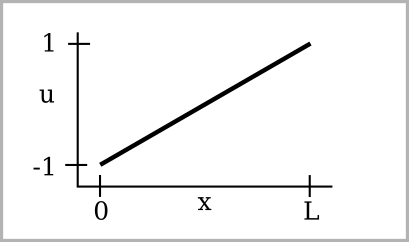
</div>


### A 3D Laplace equation in a complex domain

<div>
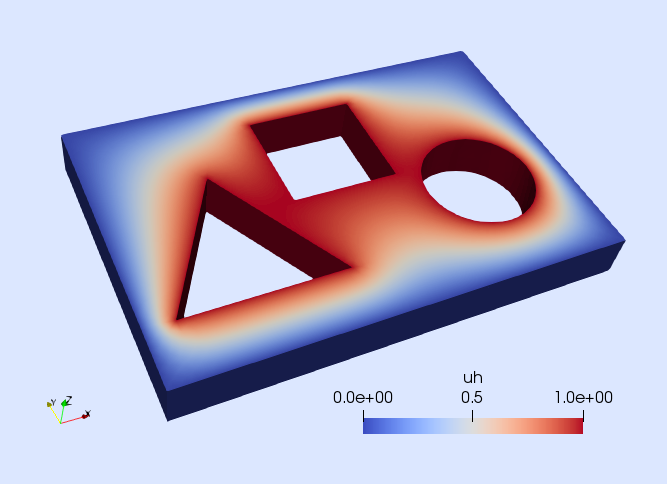
</div>


### The jacobi method

 <div>
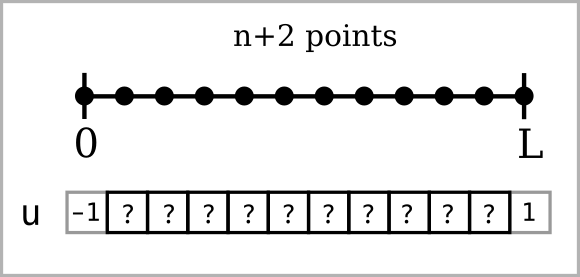
</div>

In [1]:
function jacobi(n,nsteps)
    u = zeros(n+2)
    u_new = zeros(n+2)
    u[1] = -1
    u[end] = 1
    for istep in 1:nsteps
        for i in 2:(n+1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u[2:end-1] = u_new[2:end-1]
    end
    u
end

jacobi (generic function with 1 method)

In [2]:
jacobi(5,1000)

7-element Vector{Float64}:
 -1.0
 -0.6666666666666666
 -0.3333333333333333
  0.0
  0.3333333333333333
  0.6666666666666666
  1.0

## Parallelization strategy

### Data partition and dependencies

`u_new[i] = 0.5*(u[i-1]+u[i+1])`

 <div>
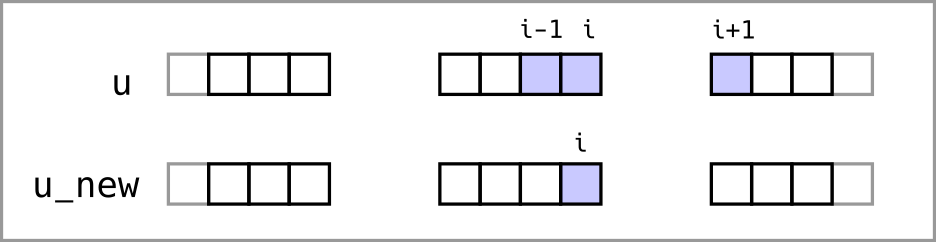
</div>


### "Ghost" entries


 <div>
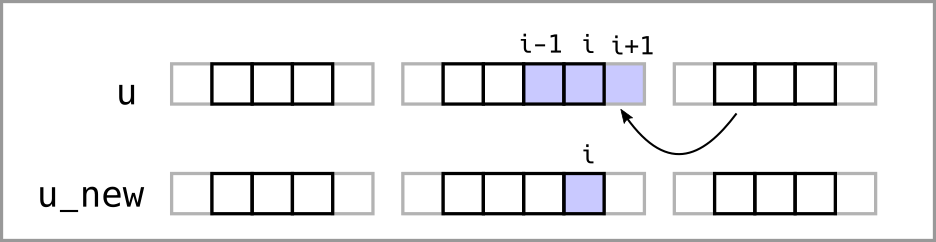
</div>


### Remote channels


 <div>
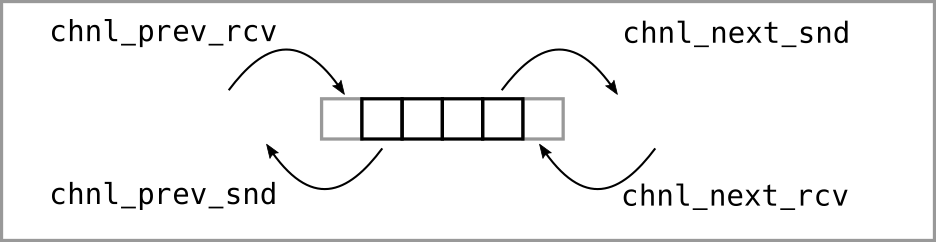
</div>

## Implementation

### Disclaimer

The most natural way of implementing a distributed Jacobi method is to use a library that provides distributed arrays:

- [DistributedArrays.jl](https://github.com/JuliaParallel/DistributedArrays.jl)
- [PartitionedArrays.jl](https://github.com/fverdugo/PartitionedArrays.jl)

We will use low-level Julia functions as an academic exercise.


### Adding some procs

In [ ]:
using Distributed

In [ ]:
addprocs(3)

### Helper functions

In [ ]:
@everywhere function initialize_vectors(n)
  @assert mod(n,nworkers()) == 0
  local_n = div(n,nworkers())
  u = zeros(local_n+2)
  u_new = zeros(local_n+2)
  u[1] = -1.0
  u[end] = 1.0
  u,u_new
end

In [ ]:
@everywhere function compute_error(u,n)
  local_n = length(u)-2
  u_exact = copy(u)
  p = myid() - 1
  for local_i in 0:(local_n+1)
    global_i =  local_i + (p-1)*local_n + 1
    Δ = 1/(n+1)
    u_exact[local_i+1] = 2*(Δ*global_i-Δ)-1
  end
  maximum(abs.(u[2:end-1].-u_exact[2:end-1]))
end

### Distributed Jacobi

In [ ]:
function jacobi_dist(n,nsteps)
  nw = nworkers()
  ftrs_prev_snd = Vector{Future}(undef,nw)
  ftrs_next_snd = Vector{Future}(undef,nw)
  fun = ()->Channel{Float64}(1)
  for w in workers()
    p = w-1
    ftrs_prev_snd[p] = @spawnat w RemoteChannel(fun,myid())
    ftrs_next_snd[p] = @spawnat w RemoteChannel(fun,myid())
  end
  ftrs = Vector{Future}(undef,nw)
  @sync for w in workers()
    ftrs[w-1] = @spawnat w jacobi_worker(
            n,nsteps,ftrs_prev_snd,ftrs_next_snd)
  end
  reduce(max,fetch.(ftrs))
end


### Exercise: complete the cell below

In [ ]:
@everywhere function jacobi_worker(
  n,nsteps,ftrs_prev_snd,ftrs_next_snd)
    u, u_new = initialize_vectors(n)
    w = myid(); p = w-1
    # TODO: Setup channels
    #chn_prev_snd
    #chn_prev_rcv
    #chn_next_snd
    #chn_next_rcv
    for step in 1:nsteps       
        # TODO: Communicate
        # Local computations
        for i in 2:(length(u)-1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u[2:end-1] = u_new[2:end-1]
    end
    @show u
    err = compute_error(u,n)
end

### Test-driven development

In [ ]:
err = jacobi_dist(6,1000)

### Remember: remote channels

 <div>
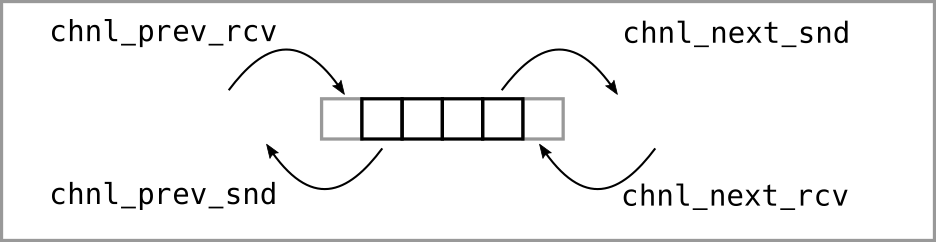
</div>

## Possible enhancements

### Is it possible to overlap computation and communication?


<div>
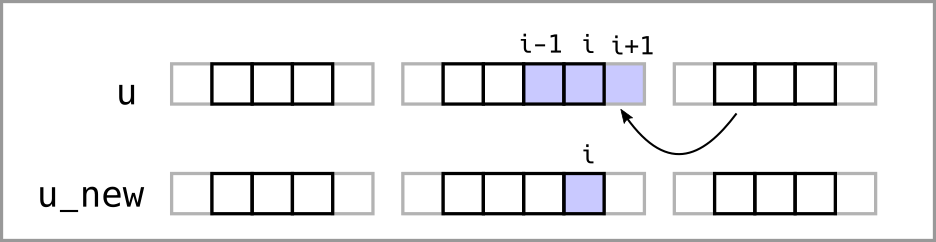
</div>


### 2nd exercise:

In [ ]:
@everywhere function jacobi_worker(
  n,nsteps,ftrs_prev_snd,ftrs_next_snd)
    u, u_new = initialize_vectors(n)
    p = myid()-1
    chn_prev_snd = fetch(ftrs_prev_snd[p])
    chn_next_snd = fetch(ftrs_next_snd[p])
    if myid()!=2
        chn_prev_rcv = fetch(ftrs_next_snd[p-1])
    end
    if myid() != nprocs()
        chn_next_rcv = fetch(ftrs_prev_snd[p+1])
    end
    for step in 1:nsteps
        # TODO overlap communication and computation
        if myid() != 2
           put!(chn_prev_snd,u[2])
           u[1] = take!(chn_prev_rcv)
        end
        if myid() != nprocs()
           put!(chn_next_snd,u[end-1])
           u[end] = take!(chn_next_rcv)
        end
        for i in 2:(length(u)-1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u[2:end-1] = u_new[2:end-1]
    end
    @show u
    err = compute_error(u,n)
end

## Solution of the exercises

### 1st exercise

In [ ]:
@everywhere function jacobi_worker(
  n,nsteps,ftrs_prev_snd,ftrs_next_snd)
    u, u_new = initialize_vectors(n)
    p = myid()-1
    chn_prev_snd = fetch(ftrs_prev_snd[p])
    chn_next_snd = fetch(ftrs_next_snd[p])
    if myid()!=2
        chn_prev_rcv = fetch(ftrs_next_snd[p-1])
    end
    if myid() != nprocs()
        chn_next_rcv = fetch(ftrs_prev_snd[p+1])
    end
    for step in 1:nsteps       
        if myid() != 2
           put!(chn_prev_snd,u[2])
           u[1] = take!(chn_prev_rcv)
        end
        if myid() != nprocs()
           put!(chn_next_snd,u[end-1])
           u[end] = take!(chn_next_rcv)
        end
        # Local computations
        for i in 2:(length(u)-1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u[2:end-1] = u_new[2:end-1]
    end
    @show u
    err = compute_error(u,n)
end

### 2nd exercise

In [ ]:
@everywhere function jacobi_worker(
  n,nsteps,ftrs_prev_snd,ftrs_next_snd)
    u, u_new = initialize_vectors(n)
    p = myid()-1
    chn_prev_snd = fetch(ftrs_prev_snd[p])
    chn_next_snd = fetch(ftrs_next_snd[p])
    if myid()!=2
        chn_prev_rcv = fetch(ftrs_next_snd[p-1])
    end
    if myid() != nprocs()
        chn_next_rcv = fetch(ftrs_prev_snd[p+1])
    end
    for step in 1:nsteps       
        if myid() != 2
           put!(chn_prev_snd,u[2])
           t1 = @async u[1] = take!(chn_prev_rcv)
        end
        if myid() != nprocs()
           put!(chn_next_snd,u[end-1])
           t2 = @async u[end] = take!(chn_next_rcv)
        end
        # Local computations (interior)
        for i in 3:(length(u)-2)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        # Wait for ghost values
        if myid() != 2
            wait(t1)
        end
        if myid() != nprocs()
            wait(t2)
        end
        # Update near boundary values
        for i in [2,length(u)-1]
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u[2:end-1] = u_new[2:end-1]
    end
    @show u
    err = compute_error(u,n)
end